In [16]:
from utils import evaluate_game
import skimage.io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path
from skimage import color
from skimage import io
import cv2 as cv
import matplotlib.image as mpimg
from skimage.transform import resize
card_dict={'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'J':10,'Q':11,'K':12}
order_dict={'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'10':10,'11':11,'12':12,'13':13}
num_dict={'0':1,'1':1,'2':1,'3':1,'4':1,'5':1,'6':1,'7':1,'8':1,'9':1,'J':0,'Q':0,'K':0}

In [23]:
def generate_ordered_cgt_mask(cgt_rank):
    cgt_number=np.zeros((13,4), dtype=int)
    cgt_mask=np.zeros((13,4), dtype=int)
    i=0
    j=0
    for n in cgt_rank:
        i=i+1
        j=0
        for e in n:
            j=j+1
            cgt_number[i-1][j-1]=card_dict[e[0]]
            cgt_mask[i-1][j-1]=num_dict[e[0]]
    cgt_order=cgt_number.transpose().reshape(-1).tolist()
    cgt_mask_order=cgt_mask.transpose().reshape(-1).tolist()
    return cgt_order, cgt_mask_order
def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

In [25]:
label_card=[]
mask_card=[]
for i in range(6):
    j=i+1
    cgt = pd.read_csv('train_games/game'+str(j)+'/game'+str(j)+'.csv', index_col=0)
    cgt_rank = cgt[['P1', 'P2', 'P3', 'P4']].values
    cgt_order, cgt_mask_order=generate_ordered_cgt_mask(cgt_rank)
    label_card=label_card+cgt_order
    mask_card=mask_card+cgt_mask_order
for i in range(13*4*6):
    if mask_card[i]==0:
        label_card[i]='d'
print(label_card)
while True:
    try:
        label_card.remove('d')
    except ValueError:
        break
print(label_card)

\SP_UM\Ju
C:\SP_UM


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\SP_UM\\train_games\\game1\\game1.csv'

cards


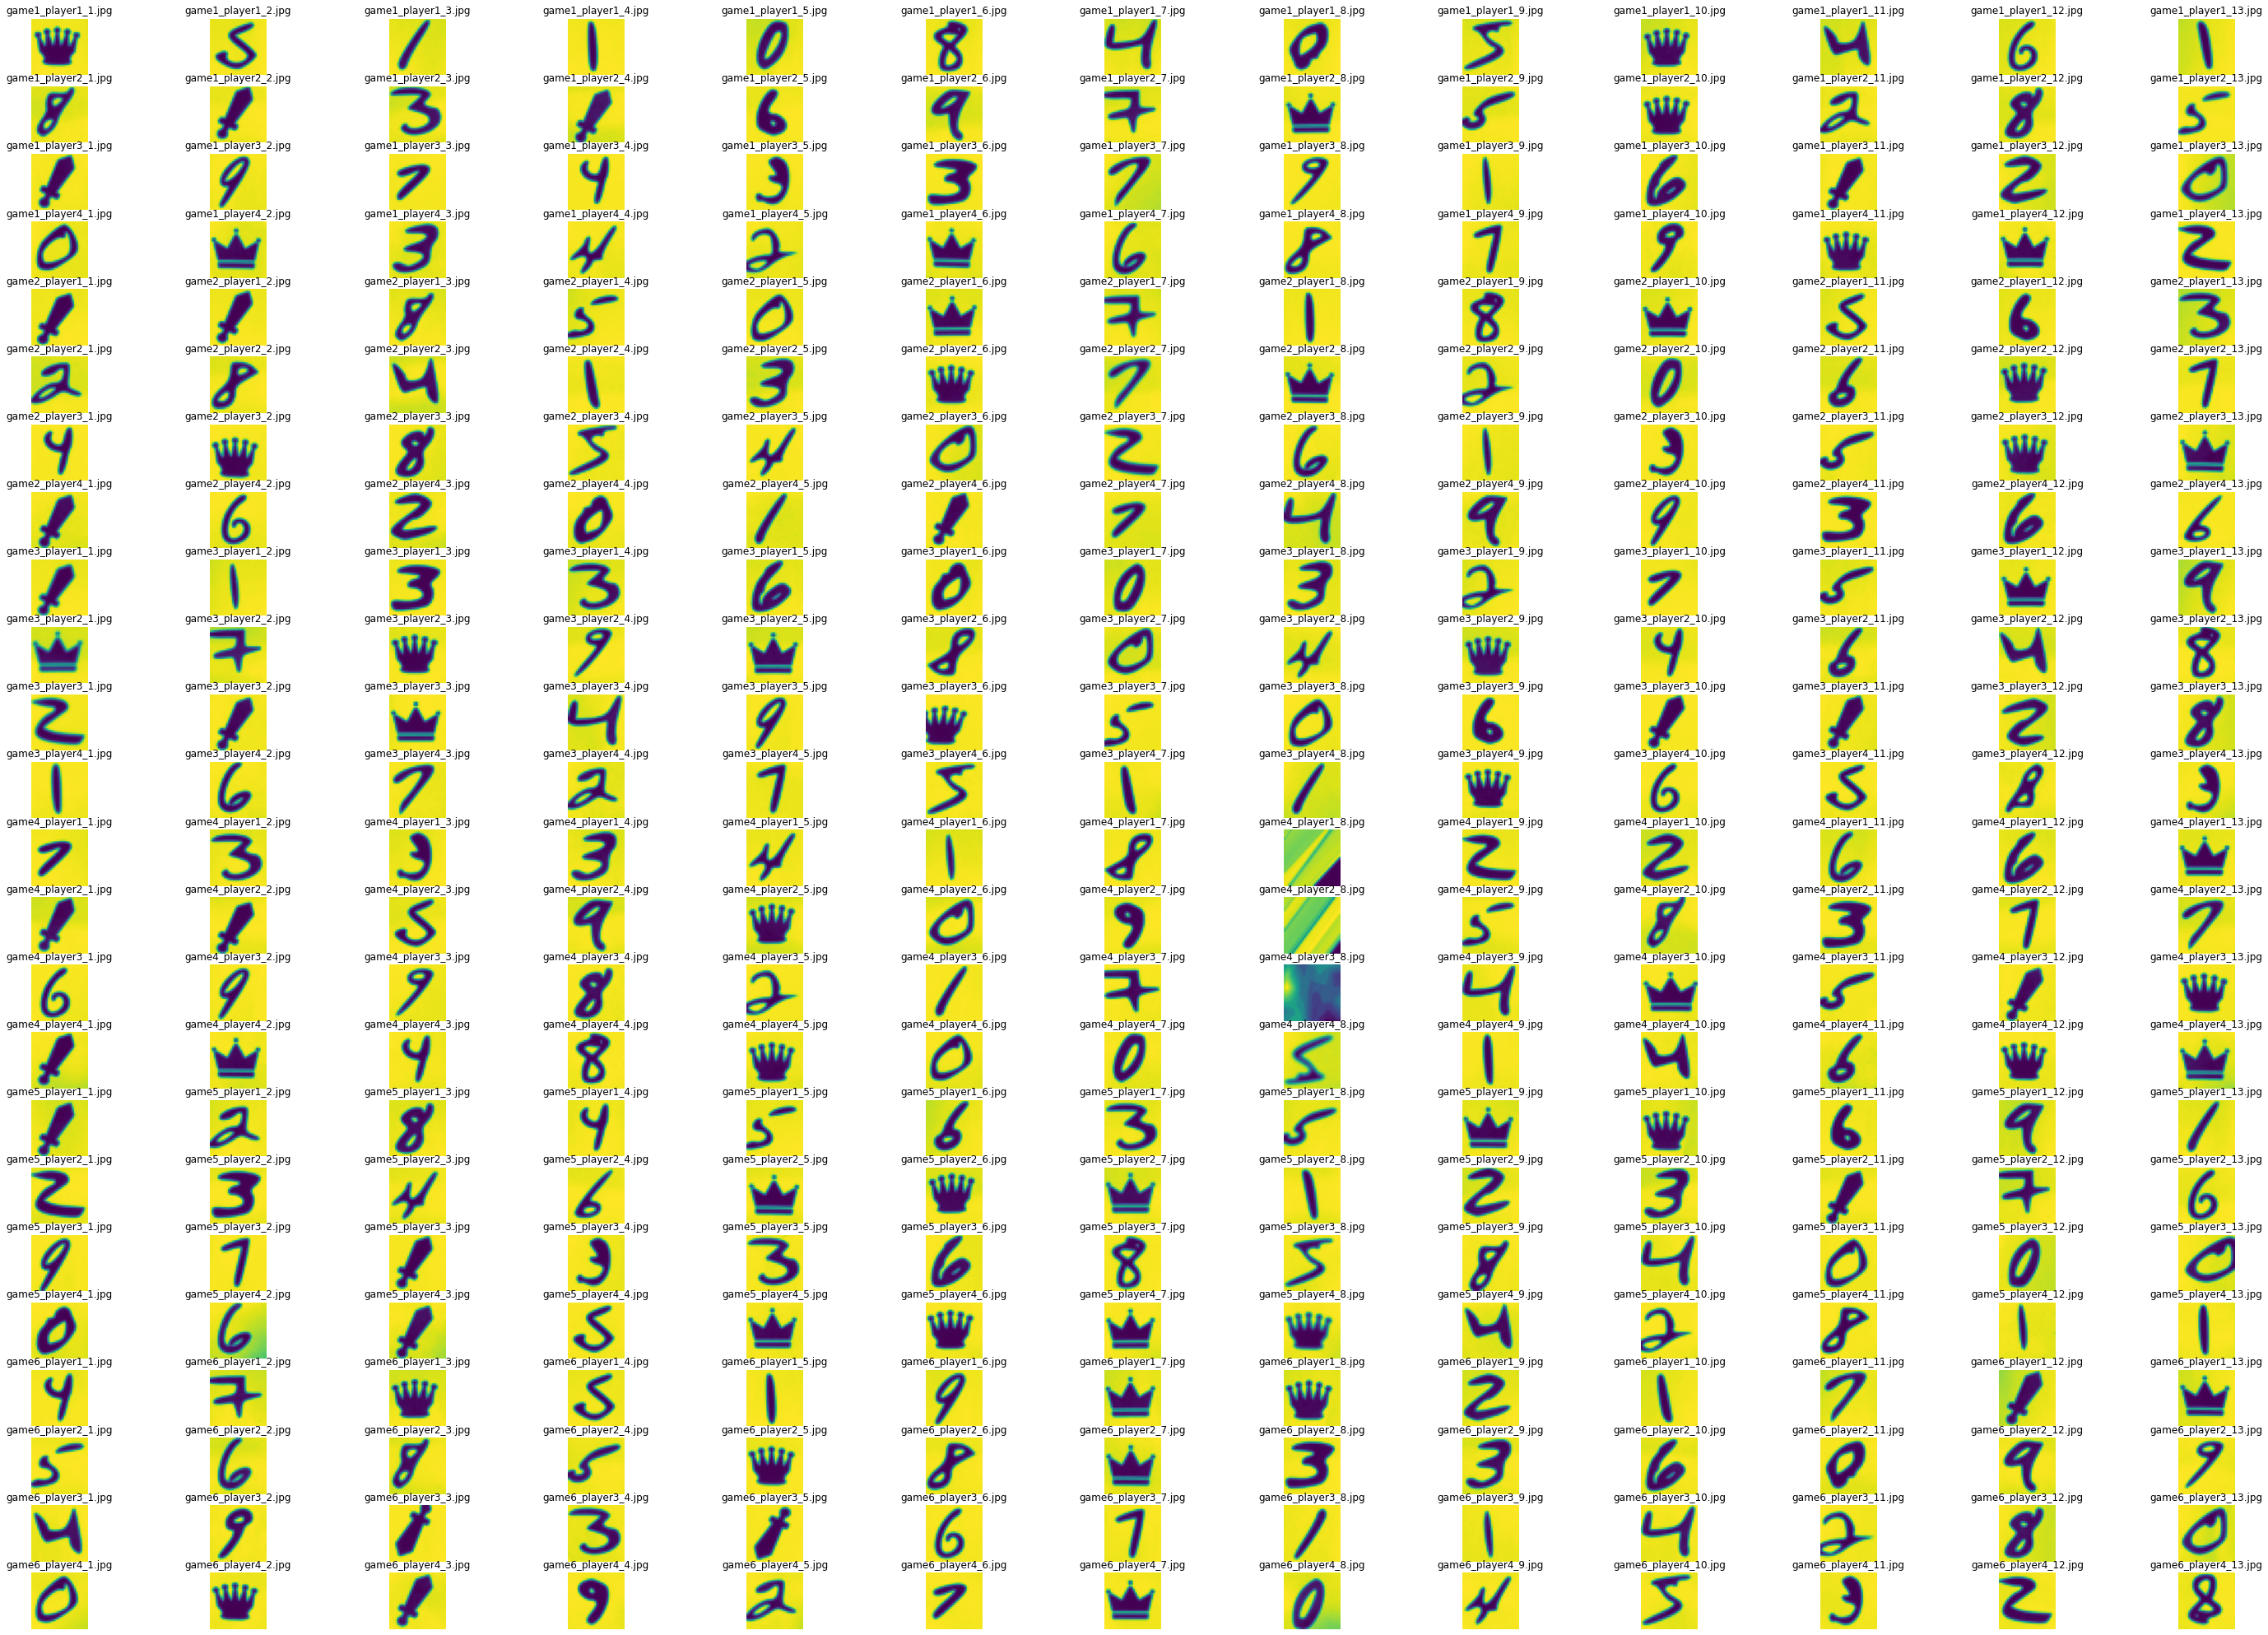

In [76]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 

def sorter(item):
    g_p_l=item.split('_')
    game =g_p_l[0] 
    player= g_p_l[1]
    loop= g_p_l[2]
    loop_n=loop.split('.')
    return (game, player,order_dict[loop_n[0]])

digit_path = os.path.join('cards')
print(digit_path)
digit_names = [nm for nm in os.listdir(digit_path) if '.jpg' in nm]  # make sure to only load .png
sorted_names = sorted(digit_names, key=sorter)
ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in sorted_names])
digit_im = skimage.io.concatenate_images(ic)
img_crop_gray=np.zeros((4*13*6,180,180)) 
img_resize_test=np.zeros((4*13*6,28,28)) 
# Plot images
fig, axes = plt.subplots(24, 13, figsize=(50, 36))
for i in range(24):
    for j in range(13):
        ax=axes[i][j]
        im=digit_im[13*i+j]
        nm=sorted_names[13*i+j]
        gray_im = rgb2gray(im) 
        img_crop_gray[13*i+j]=gray_im[110:290,70:250]
        img_resize_test[13*i+j]=resize(gray_im[110:290,70:250], (28, 28))
        ax.imshow(img_resize_test[13*i+j])
        ax.axis('off')
        ax.set_title(nm)
        

In [107]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import os

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

image_shape = (28, 28)
train_set_size = 500


data_folder = os.path.join("mnist_data")

train_images_path = os.path.join(data_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)


In [108]:
from sklearn.neural_network import MLPClassifier
card_label_test=np.array(label_card)
# reshape input x into 784-dimensional
size_train = train_images.shape[0]

x_train=np.concatenate((train_images,delete_jqk),axis=0)
x_train = np.reshape(train_images, [size_train, 784])
y_train = train_labels
y_train=np.concatenate((y_train,card_label_test),axis=0)

delete_jqk=img_resize_test[np.array(mask_card)==1,:,:]

size_test = delete_jqk.shape[0]
#size_test = test_images.shape[0]

x_test = np.reshape(delete_jqk, [size_test, 784])
y_test = card_label_test
#y_test = test_labels
#x_test = np.reshape(test_images, [size_test, 784])
# 100 hidden units
MLP_clf = MLPClassifier(hidden_layer_sizes=100)

# training the MLP
MLP_clf.fit(x_test, y_test)

# Get the predicted result
y_pred = MLP_clf.predict(x_test)

# Calculate the accuracy
tmp = np.abs(y_pred - y_test)
score=np.zeros(tmp.shape)
score[tmp==0] = 1
accuracy = 1.0 - np.sum(tmp) / size_test
print("Accuarcy: ",  np.sum(score)/size_test)

Accuarcy:  0.9665271966527197


(28, 28)
(180, 180)
(28, 28)
(2, 3, 3)
[[3. 3. 4.]
 [1. 2. 3.]
 [5. 6. 7.]]


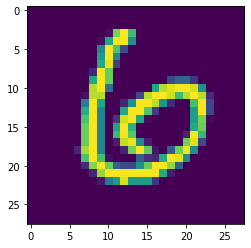

In [67]:
from skimage.transform import resize
import matplotlib.pyplot as plt
imt=test_images[11]
print(imt.shape)
plt.imshow(imt)

img=img_crop_gray[10]
print(img.shape)
image_resized =resize(img, (28, 28))
print(image_resized.shape)
#plt.imshow(image_resized)
xx=np.zeros((2,3,3))
print(xx.shape)
xx[0]=np.array([[3,3,4],[1,2,3],[5,6,7]])
print(xx[0])

In [104]:
print(img_resize_test.shape)
print(test_images.shape)
np.concatenate((img_resize_test, test_images), axis=0).shape

(312, 28, 28)
(10000, 28, 28)


(10312, 28, 28)

In [97]:
print(img_resize_test[np.array(mask_card)==1,:,:].shape)
np.array(mask_card).sum()

(239, 28, 28)


239

In [70]:
print(y_pred)

[5 8 8 8 8 8 2 5 8 8 2 8 8 8 2 8 8 8 2 3 3 8 3 8 8 3 8 2 8 8 8 8 8 8 8 8 5
 8 8 8 8 8 3 5 3 8 8 8 8 8 3 3 5 5 8 3 8 8 2 8 8 3 8 3 8 8 8 2 8 8 5 8 3 3
 8 8 3 8 8 3 8 8 3 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8 2 2 2 5 8 8 5 8 3 8 8 8 8
 8 3 8 8 3 8 3 3 5 8 8 2 8 3 8 8 8 2 8 3 8 3 2 2 8 8 8 8 5 8 8 8 8 8 8 8 8
 8 8 8 3 8 8 8 8 8 8 8 8 3 8 2 8 3 8 8 8 3 8 5 8 8 3 8 8 8 3 8 3 8 8 8 2 8
 8 3 8 2 8 2 3 8 8 3 2 3 8 8 8 8 8 8 8 2 8 3 8 8 8 8 2 8 8 8 8 8 8 3 2 8 3
 3 3 8 3 3 8 8 8 8 5 3 8 2 8 5 8 8 8 8 8 8 2 8 8 8 8 8 8 8 3 5 3 3 2 5 8 8
 8 2 2 8 8 8 2 8 8 8 8 8 8 3 3 8 8 8 5 8 8 3 8 8 5 8 8 2 8 2 8 5 8 8 8 8 2
 5 8 8 8 3 8 8 8 8 3 8 3 8 8 3 8]


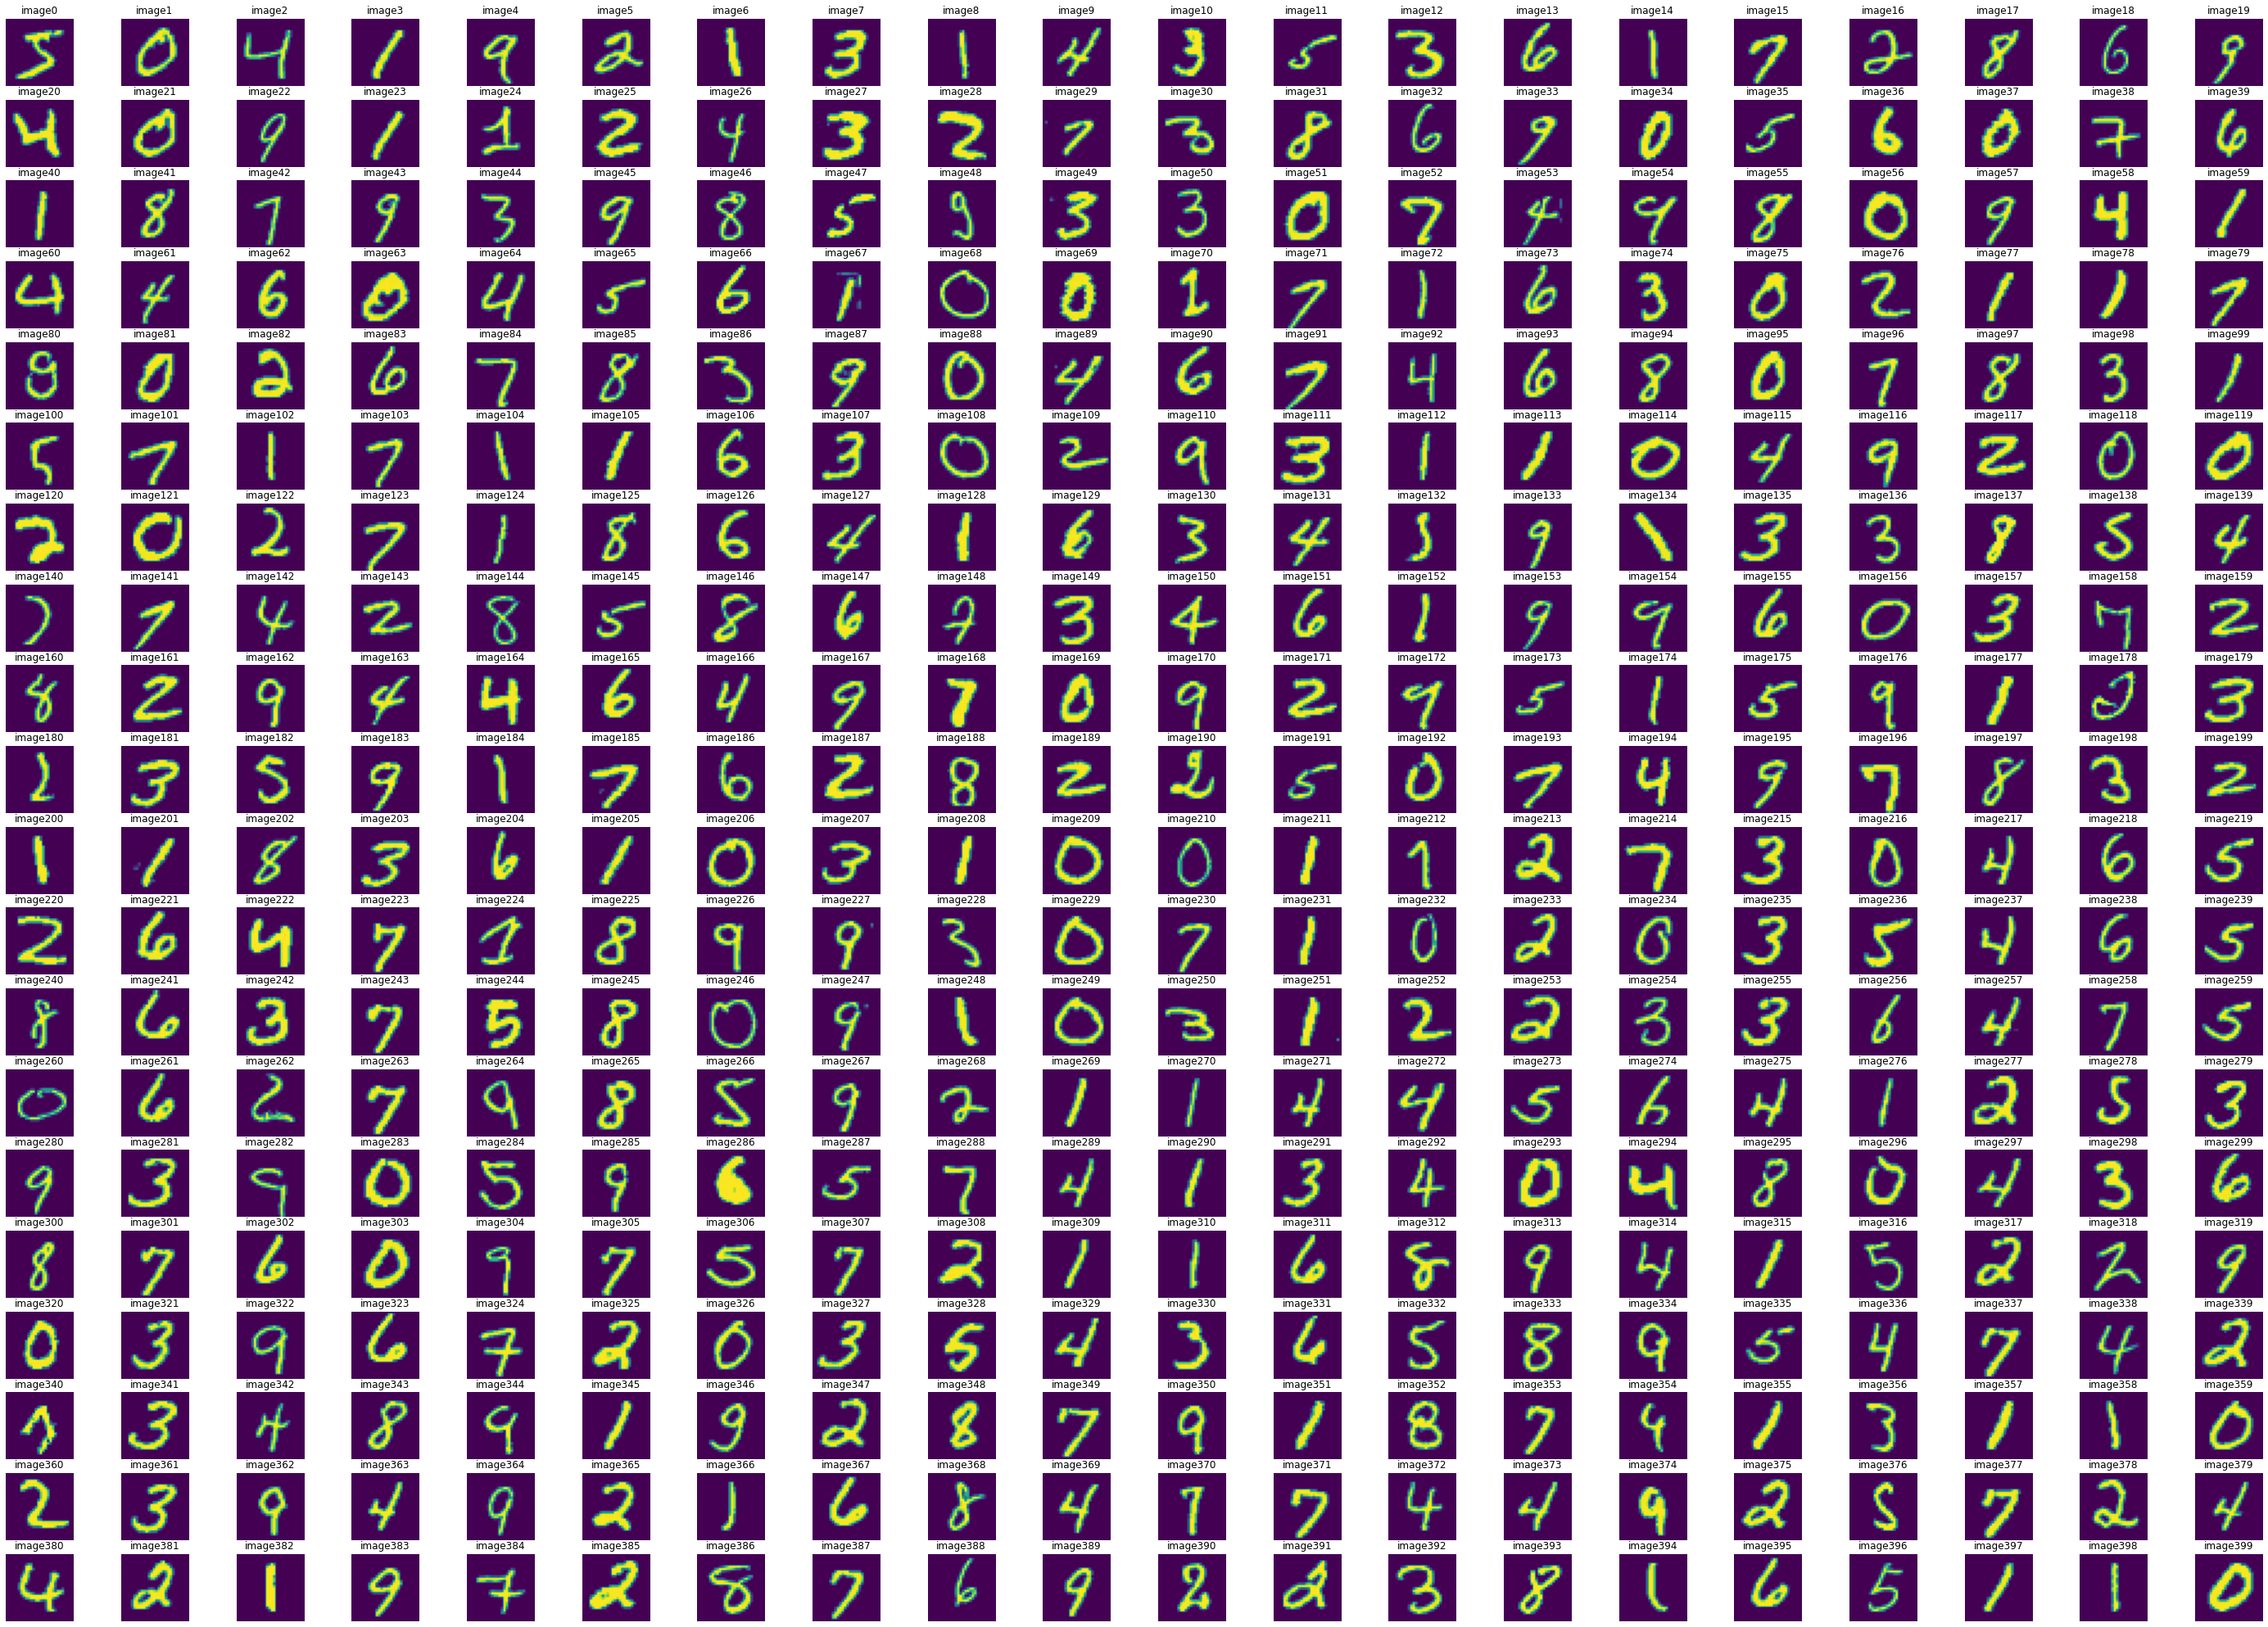

In [79]:
fig, axes = plt.subplots(20, 20, figsize=(50, 36))
for i in range(20):
    for j in range(20):
        ax=axes[i][j]
        im=train_images[20*i+j]
        nm="image"+str(20*i+j)
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(nm)